In [1]:
# So I think we could just use scipy's integrator for the electronic dofs and verlet for the nucelar dofs.
# use the same model potential as in the fssh notebook to make a comparison.

import numpy as np
from math import pi
from ipywidgets import Button, FloatSlider, HBox, VBox, IntProgress,Output
from ipywidgets import Dropdown, Layout, Accordion, Label
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime
import math
import scipy.integrate
%matplotlib notebook
pause = False
output = Output(layout=Layout(width="400px"))
N_trajs = 100
step=0
######################################################################
# Set up plot

######################################################################
# Create the animation

# specify time steps and duration


# Tully 1 for starters
class tully1:
    def __init__(self, A = 0.01, B = 1.6, C = 0.005, D = 1.0):
        self.A = A
        self.B = B
        self.C = C
        self.D = D

    def V(self,x):
        if x > 0:
            v11 = self.A* ( 1.0 - np.exp(-self.B *x) )
        else:
            v11 = -self.A* ( 1.0 - np.exp(self.B *x) )
        v22 = -v11
        v12 = self.C * np.exp(-self.D*x**2)
        V_ = np.array([[v11, v12], [v12, v22]])
        return V_

    def dV(self, x):
        v11 = self.A * self.B * np.exp(-self.B * abs(x))
        v22 = -v11
        v12 = -2.0 * self.C * self.D * x * np.exp(-self.D *x**2)
        dV_ = np.array([[v11, v12], [v12, v22]])
        return dV_


class Ehrenfest:
        def __init__(self, model, nuc_pos, vel, mass, dt):

            self.time = 0.
            self.model = model
            self.nuc_pos = nuc_pos
            self.dt = dt
            self.mass = mass
            self.vel = vel
            self.F = 0. # force
            self.nstates=2
            self.accel = 0.
            self.V = self.model.V
            self.dV = self.model.dV
            self.ke = 0.
            self.pe = 0.
            self.tot_e = 0.
            self.elec_energies, self.evecs = np.linalg.eigh(self.V(self.nuc_pos))
            self.elec_coeffs = np.array([1,0])
            self.rho  = np.zeros([2,2], dtype = np.complex64)
            self.rho[0,0]=1.
            self.p1 = np.real(self.rho[0,0])
            self.p2 = np.real(self.rho[1,1])
            self.dij = np.zeros((2,2))
            self.nac_mat = np.zeros((2,2))
            # if ref_coeff is not None:
            #     for mo in range(self.nstates()):
            #         if (np.dot(self.coeff[:,mo], ref_coeff[:,mo]) < 0.0):
            #             self.coeff[:,mo] *= -1.0




        def diag_Vmat(self):
            #     print(V)
            self.elec_energies, self.evecs = np.linalg.eigh(self.V(self.nuc_pos))

        def getHFforce(self):

            force = 0.
            dV = self.dV(self.nuc_pos)
            for i,bra in enumerate(self.evecs):
                for j,ket in enumerate(self.evecs):
                    bra=np.conj(bra)
                    force -= np.conj(self.rho[i,j])*(np.dot(bra, np.dot(dV,ket)))
                    
            self.F = np.real(force)
          

            
        def run_single_step(self):
                    
            self.nuc_pos += self.vel*self.dt
            self.diag_Vmat()
            
            self.getHFforce()
            self.accel = self.F/self.mass
            self.vel += self.accel*self.dt
            self.elec_prop()
            self.time += self.dt
            # compute observables
            self.compute_pops()
            self.calc_pe()
            self.calc_kinetic_energy()
            self.calc_total_energy()
                        

       
        def calc_kinetic_energy(self):
            self.ke= 0.5 * self.mass * self.vel**2
        
        def calc_pe(self):
            pe = 0.
            V = self.V(self.nuc_pos)
            for i,bra in enumerate(self.evecs):
                for j,ket in enumerate(self.evecs):
                    bra=np.conj(bra)
                    pe += np.conj(self.rho[i,j])*(np.dot(bra, np.dot(V,ket)))
                    
            self.pe = pe
            
        def calc_total_energy(self):
            self.tot_e = self.ke + self.pe            

        def compute_couplings(self,i,j):
            dV = self.dV(self.nuc_pos)
            if (i != j):
        
                self.dij[i,j] = np.dot(np.conj(self.evecs[:,i]), np.dot(dV[:,:], self.evecs[:,j]))
            
                #                dij = np.outer(elec_coeffs, dV@elec_coeffs)[i][j]
                dE = self.elec_energies[j] - self.elec_energies[i]
                if abs(dE) < 1.0e-14:
                    if dE < 0:
                        dE = -1.0e-14
                    else:
                        dE = 1.0e-14
                self.dij[i,j] = self.dij[i,j] / dE


        def compute_nac(self):
            nac_mat = np.zeros([2,2], dtype=np.complex64)
            for i in range(2):
                for j in range(i):
                    self.compute_couplings(i,j)
                    #print("vel = {}".format(vel))
                    self.nac_mat[i, j] = self.vel*self.dij[i,j]
                    self.nac_mat[j, i] = - self.nac_mat[i, j]

        def compute_pops(self):
            self.p1 = np.real(self.rho[0,0])
            self.p2 = np.real(self.rho[1,1])

        
        def elec_prop(self):

            self.compute_nac()
            V = self.V(self.nuc_pos)
            prop_mat = np.zeros([2,2], dtype=np.complex64)
            prop_mat[0,0] = self.elec_energies[0]
            prop_mat[1,1] = self.elec_energies[1]
            prop_mat -= 1j * self.nac_mat

        
            diags, coeff = np.linalg.eigh(prop_mat)
            cmat = np.matrix(coeff)
            cmat_T = cmat.getH()
            cconj = np.array(cmat_T)
            tmp_rho = np.dot(cconj, np.dot(self.rho, coeff))
            for i in range(self.nstates):
                for j in range(self.nstates):
                    tmp_rho[i,j] *= np.exp(-1j * (diags[i] - diags[j]) * self.dt)
            self.rho[:] = np.dot(coeff, np.dot(tmp_rho, cconj))
            #print("elec_coeffs = {}".format(elec_coeffs))



time=0.
ndim=1
num_states=2
# specify constants
hbar = 1.0   # planck's constant
mass = 2000.      # particle mass
F = 0.
momentum = 22.0
vel = momentum/mass
dt=0.01/vel
pe_model = tully1()


N_steps = 2000
t_max = 120


V = np.zeros((2,2))
dV = np.zeros((2,2))
elec_energies = np.zeros(2)
elec_coeffs = np.array([1,0])


nuc_pos=-10.0


Eh = Ehrenfest(pe_model, nuc_pos, vel, mass, dt)



<IPython.core.display.Javascript object>


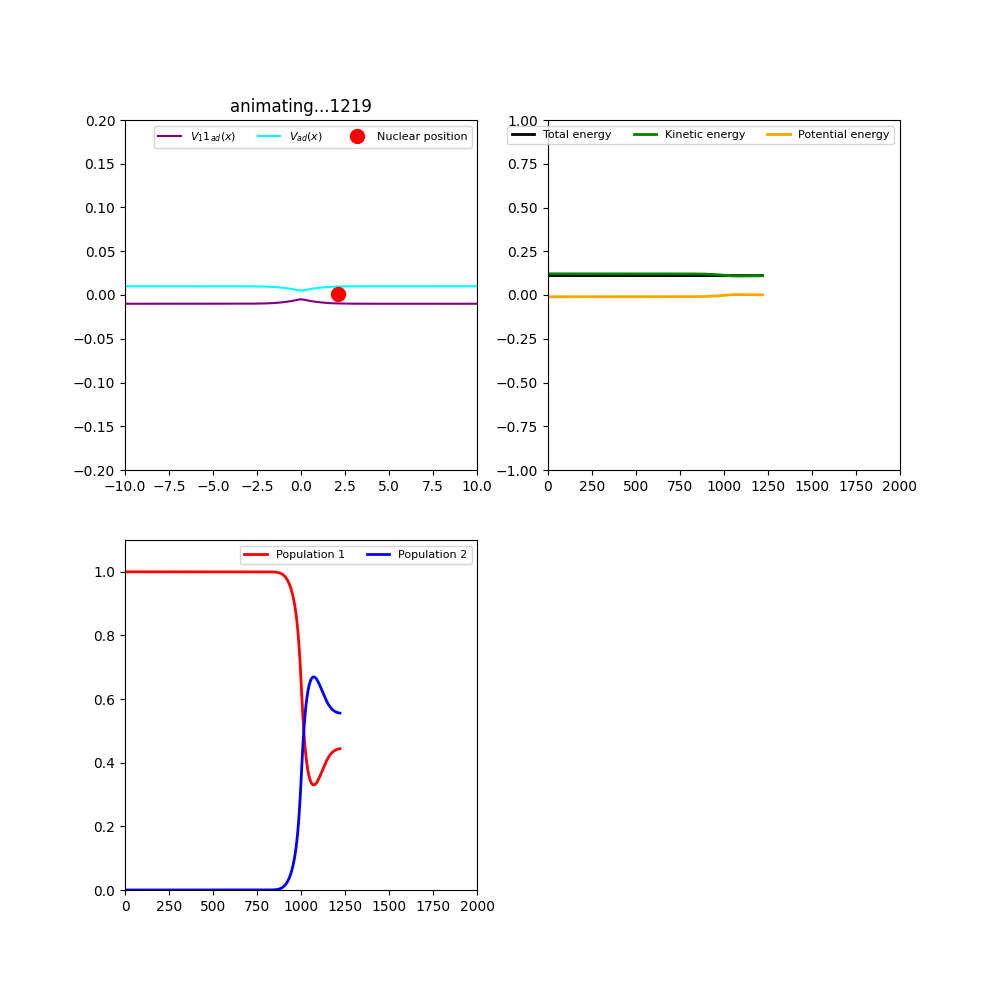

Button(description='Pause', style=ButtonStyle())

In [2]:
def init():
   
    V1_ad_x_line.set_data([],[])
    V2_ad_x_line.set_data([],[])
    ke_line.set_data([],[])
    pe_line.set_data([],[])
    tot_e_line.set_data([],[])
    pop1_line.set_data([],[])
    pop2_line.set_data([],[])


   
    title.set_text("Title")
    
    return V1_ad_x_line,V2_ad_x_line,pop1_line,pop2_line



fig = plt.figure(figsize=(10,10))
fig.canvas.header_visible = True
# plotting limits
xlim = (-10, 10)
# tlim = (0,S.tot_steps)
Nx = 1000
N_steps = 2000


x = np.linspace(-10,10,Nx)
pes = np.zeros((Nx,2))

for i,pos in enumerate(x):
    
    V = pe_model.V(pos)
#     print(V)
    energy_arr, coeffs = np.linalg.eigh(V)
    pes[i,:] = np.array(energy_arr)


# ymin = 0.
# if pot_select.index == 0:
#     ymax = 1.0 
#     ylims=(ymin - 0.2 * (ymax - ymin),
#                             ymax + 0.2 * (ymax - ymin))
# else:
xlim=(-10,10)
ylims=(-0.2,0.2)
    
Elims=(-1,1)
poplims=(0,1.1) 
tlims=(0,N_steps)
ax1 = fig.add_subplot(221, xlim=xlim,
                      ylim=ylims)
ax2 = fig.add_subplot(222, xlim=tlims,
                      ylim=Elims)

# subplot for populations
ax3 = fig.add_subplot(223, xlim=tlims,
                      ylim=poplims)

# psi1_x_line, = ax1.plot([], [], c='r', label=r'$|c_1(x)|$', linewidth=1.2)

V1_ad_x_line, = ax1.plot([], [], c='purple', label=r'$V_11_{ad}(x)$')
V2_ad_x_line, = ax1.plot([], [], c='cyan', label=r'$V_{ad}(x)$')#
V1_ad_x_line.set_data(x,pes[:,0])
V2_ad_x_line.set_data(x,pes[:,1])       
pos_marker, = ax1.plot([], [], 'ro', ms=10, label='Nuclear position')
      
tot_e_line, = ax2.plot([], [], c='black', label=r'Total energy', linewidth=2.0)
ke_line, = ax2.plot([], [], c='green', label=r'Kinetic energy', linewidth=2.0)
pe_line, = ax2.plot([], [], c='orange', label=r'Potential energy', linewidth=2.0)
pop1_line, = ax3.plot([], [], c='red', label=r'Population 1', linewidth=2.0)
pop2_line, = ax3.plot([], [], c='blue', label=r'Population 2', linewidth=2.0)

title = ax1.set_title("")
ax1.legend(prop=dict(size=8), ncol=4, loc=1)
ax2.legend(prop=dict(size=8), ncol=4, loc=1)
ax3.legend(prop=dict(size=8), ncol=4, loc=1)

           


def animate(i):
    global title,output,Eh, step, N_steps

  
    global pe_list, ke_list,tot_e_list,pop1_list, pop2_list,pause, button_pause #, pop1_line, pop2_line
    # can just set pause = True after each step in the algo
  
    Nx = 1000
    x = np.linspace(-10,10,Nx)
   
    if not pause:
        if step<N_steps:  
            Eh.run_single_step()
            p1 = Eh.p1
            p2 = Eh.p2
            pop1_list.append(p1)
            pop2_list.append(p2)
            tot_e_list.append(Eh.tot_e)
            ke_list.append(Eh.ke)
            pe_list.append(Eh.pe)

            #         pop1_list.append(np.linalg.norm(p1))
    # #         with output:
    # #             print("pop1_list = {}".format(pop1_list))
    #         pop2_list.append(np.linalg.norm(p2))
            step+=1
        else:
            time=0.
            step = 0
            ndim=1
            num_states=2
            # specify constants
            hbar = 1.0   # planck's constant
            mass = 2000.      # particle mass
            F = 0.
            momentum = 22.0
            vel = momentum/mass
            dt=0.01/vel
            pe_model = tully1()


            N_steps = 2000
            t_max = 120


            V = np.zeros((2,2))
            dV = np.zeros((2,2))
            elec_energies = np.zeros(2)
            elec_coeffs = np.array([1,0])
            nuc_pos=-10.0

            Eh = Ehrenfest(pe_model, nuc_pos, vel, mass, dt)

            tot_e_list = []
            pe_list = []
            ke_list = []
            pop1_list = []
            pop2_list = []
    else:
        pause=True
        button_pause.description = "Play"
        anim.event_source.stop()

    

    V1_ad_x_line.set_data(x,pes[:,0])
    V2_ad_x_line.set_data(x,pes[:,1]) 
    tot_e_line.set_data(np.arange(step),tot_e_list)
    ke_line.set_data(np.arange(step),ke_list)
    pe_line.set_data(np.arange(step),pe_list)
    pop1_line.set_data(np.arange(step),pop1_list)
    pop2_line.set_data(np.arange(step),pop2_list)
    

    mean_pe = p1*Eh.elec_energies[0] + p2*Eh.elec_energies[1]
    pos_marker.set_data(Eh.nuc_pos,mean_pe) # draw marker on active surface

#     pos_marker.set_data(nuc_pos,elec_energies[0]) # draw marker on active surface
#     pos_marker.set_data(0,0)


    title.set_text("animating...{}".format(i))

    return  V1_ad_x_line,  V2_ad_x_line, pos_marker, pop1_line, pop2_line, title


tot_e_list = []
pe_list = []
ke_list = []
pop1_list = []
pop2_list = []




with output:
            print("init animation")
anim = animation.FuncAnimation(fig, animate,frames=N_steps, interval=0.1, blit=False,repeat=True)
#fig.show()

def onClick(event):
    global pause,anim
    pause ^= True
    with output:
        print("onClick")
    
    if button_pause.description == "Pause":
        button_pause.description = "Play"
        print("pausing")

        anim.event_source.stop()
    else:
        button_pause.description = "Pause"
        with output:
            print("playing")
        anim.event_source.start()
       


button_pause = Button(description="Pause");
button_pause.on_click(onClick)
display(button_pause);

In [3]:
display(output)

Output(layout=Layout(width='400px'))